# Проект 1799: "Разработка системы предсказания параметров цифровых схем с использованием методов машинного обучения"  
## Первые шаги, в предсказании Площади и Задержки схем

# Подготовка и исследование данных

## Импорт всех библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor  
import lightgbm as lgb
import tensorflow as tf
import joblib
import optuna

2024-03-22 10:11:26.312771: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 10:11:26.359474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 10:11:27.182086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Загрузка и очистка от выбросов

In [2]:
# Загрузка данных
df1 = pd.read_csv('data_optimized_1.csv')
df2 = pd.read_csv('data_optimized_2.csv')
df3 = pd.read_csv('data_optimized_3.csv')
df4 = pd.read_csv('data_optimized_4.csv')

# Соединение датафреймов друг с другом
data = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44623 entries, 0 to 44622
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       44623 non-null  object 
 1   Area       43395 non-null  float64
 2   Delay      43395 non-null  float64
 3   embedding  43395 non-null  object 
dtypes: float64(2), object(2)
memory usage: 1.4+ MB


Видим, что имеются пропуски в значениях т.к. количество ненулевых значений в стобцах Area, Delay и embadding не совпадает с общим числом значений. Значения, которые имеют пропуски в этих ячейках, для обучения не подходят. Очистим данные от пропусков. Важно не забыть, что после использования функции(метода) dropna нумерация будет не последовательной, что может привести к ошибкам в будущем. Стоит сразу же это исправить

In [4]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43395 entries, 0 to 43394
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       43395 non-null  object 
 1   Area       43395 non-null  float64
 2   Delay      43395 non-null  float64
 3   embedding  43395 non-null  object 
dtypes: float64(2), object(2)
memory usage: 1.3+ MB


Проверим наличие выбросов в значениях параметров Задержки и площади:

In [6]:
print("Максимальная задержка: ", data['Delay'].max())
print("Минимальная задержка: ", data['Delay'].min())
print("Максимальная площадь: ", data['Area'].max())
print("Минимальная площадь: ", data['Area'].min())

Максимальная задержка:  1129.6
Минимальная задержка:  -1000000000.0
Максимальная площадь:  1189.38
Минимальная площадь:  0.0


Видим, что в таблице присутствуют некорректные данные, с площадью равной 0 и устремленным в минус бесконечность временем задержки. Для улучшения качества обучения, необходимо избавиться от таких данных

In [7]:
data.drop(data[data['Delay'] == data['Delay'].min()].index, inplace=True)
data.drop(data[data['Area'] == data['Area'].min()].index, inplace=True)
data.reset_index(drop=True, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41867 entries, 0 to 41866
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       41867 non-null  object 
 1   Area       41867 non-null  float64
 2   Delay      41867 non-null  float64
 3   embedding  41867 non-null  object 
dtypes: float64(2), object(2)
memory usage: 1.3+ MB


## Проверка корректности данных. Поиск выбросов

В этом месте, необходимо произвести оценку данных. Вывести графическую статистику по Area и Delay. Задача - определить значения, которые являются выбросами и удалить эти строки из DF. Таким образом, данные будут лучше подобраны для обучения

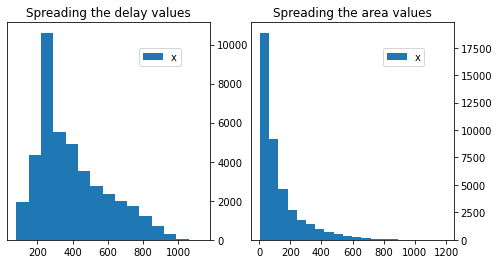

In [9]:
fig, (ax1, ax2) = plt.subplots( #делаем полотно с несколькими графиками
    nrows=1, ncols=2, # расположенными в один ряд два столбца
    figsize=(8, 4) # размер полотна
) #

ax1.hist( # строим второй график - гистограмму
    data['Delay'], bins=15, # задаем данные и диапазоны
    label=('x', 'y') # и подписи данных
)

ax1.legend(loc=(0.65, 0.8)) # отображаем легенду и задаем ее расположение
ax1.set_title('Spreading the delay values') # название второго графика
ax1.yaxis.tick_right() # устанавливаем, что вертикальная ось должна быть справа

ax2.hist( # строим второй график - гистограмму
    data['Area'], bins=20,  # задаем данные и диапазоны
    label=('x', 'y') # и подписи данных
)

ax2.locator_params (axis='x', nbins=10)
ax2.legend(loc=(0.65, 0.8)) # отображаем легенду и задаем ее расположение
ax2.set_title('Spreading the area values') # название второго графика
ax2.yaxis.tick_right() # устанавливаем, что вертикальная ось должна быть справа

plt.show() # отображаем полотна

Видим, что значения задержи, большие 1000 (Если данных будет нехватать, то и большие 750), можно принять за выбросы. Для площади, это значения большие 150.

In [10]:
data.drop(data[data['Delay'] > 1000].index, inplace=True)
data.drop(data[data['Area'] > 600].index, inplace=True)
data.reset_index(drop=True, inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41192 entries, 0 to 41191
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       41192 non-null  object 
 1   Area       41192 non-null  float64
 2   Delay      41192 non-null  float64
 3   embedding  41192 non-null  object 
dtypes: float64(2), object(2)
memory usage: 1.3+ MB


## Парсинг эмбеддингов

In [12]:
data['embedding'][1231]

'[[-0.0023294328711926937, 0.0010059750638902187, 0.020557958632707596, 0.036383241415023804, -0.0376126691699028, -0.028824374079704285, 0.025990357622504234, 0.03626422584056854, -0.02031301148235798, -0.01526272390037775, 0.029781151562929153, -0.006153405643999577, -0.01836802251636982, 0.026345035061240196, -0.01960602030158043, -0.007308585569262505, 0.011734742671251297, 0.004220206756144762, -0.03347805514931679, -0.03825681284070015, 0.02961454726755619, 0.020517736673355103, 0.027350598946213722, 0.0030764532275497913, 0.025808831676840782], [-0.013696731068193913, -0.003834116505458951, 0.023253051564097404, -0.030173856765031815, -0.01584583893418312, -0.030236484482884407, -0.0036846150178462267, 0.03843872249126434, -0.02941228821873665, -0.009418928995728493, -0.007723821792751551, 0.032445743680000305, -0.023836053907871246, 0.00016100586799439043, -0.019183043390512466, -0.038594264537096024, 0.020150167867541313, -0.03511103242635727, -0.017706187441945076, -0.0001177

Видим, что эмбеддинги для каждой схемы хранятся в формате string, что не подходит для обучения моделей. Необходимо, преобразовать их в то, чем они являются изначально.  
Напишем программу, которая приведет текстовое представление данных к list, который будет содержать numpy массивы  
Для начала, напишем функцию, которая будет проверять, можно ли приобразовать строку в дробное число (записано ли в строке число)


In [13]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

Далее, напишем функцию, которая распарсит нашу строку на list, который будет содержать numpy массивы

In [14]:
new_embedding = []
for str in data['embedding']:
    result = []
    if '\n' in str:
        res = str.split('\n')
    else:
        res = str.split('], ')
    for mass in res:
        s = mass.replace(', dtype=float32',' ').replace('(', ' ').replace(')',' ').replace(',',' ').replace('[','').replace(']','').split(' ')
        tmp = []
        for word in s:
            if is_number(word):
                tmp.append(float(word))
        result.append(tmp)
    r = [np.array(sublist) for sublist in result]
    new_embedding.append(r)

## Приведение данных в вид, удобный для обучения

Так как каждая схема имеет свое представление в виде графа, возникла проблема, что каждая схема представлена разным количеством векторов длины 4. Т.е. каждая схема описанна массивом, содержащим в себе *n*ое количество массивов длины 4. Так как в процессе обучения, нам требуется, чтобы размерность данных для каждой схемы была единой, то нужно чем-то и до какого-то числа дополнить данные о каждой схеме.  
Идеи:  
* Находим схему, которая представлена в виде максимального количества векторов. Дополняем все остальные схемы до данной размерности
* Дополняем векторами, состоящими из нулей
* Дополняем векторами, состоящими из чисел, являющимися средним значением по всей выборке (средними значениями координат векторов)
* Дополняем векторами, состоящими из чисел, являющимися средним значением по схемам, имеющим наибольшее число векторов в представлении

В данный момент, были реализованы и проверены идеи с дополнением средним значением по всему датасету и дополнение 0. Различия по точности отсутствуют

Ниже, представлена реализация дополнения до размерности максимальной из схем, векторами, состоящими из 0


In [15]:
max_subarrays = max(len(arr) for arr in new_embedding)

for i in range(len(new_embedding)):
    while len(new_embedding[i]) < max_subarrays:
        new_embedding[i] = np.vstack([new_embedding[i], np.zeros(25)])

In [16]:
import pickle

# Создание файла для сохранения значения
file_path = 'max_subarrays.pickle'
with open(file_path, 'wb') as f:
    # Сохранение значения переменной в файл
    pickle.dump(max_subarrays, f)

Ниже, представленна реализация дополнения до размерности максимальной из схем векторами, состоящими из средних значений по всей выборке

In [17]:
#lst = []
#for i in new_embedding:
#    for k in i:
#        lst.append(k.mean())
#val = np.array(lst).mean()

In [18]:
#max_subarrays = max(len(arr) for arr in new_embedding)
#
#for i in range(len(new_embedding)):
#    while len(new_embedding[i]) < max_subarrays:
#        new_embedding[i] = np.vstack([new_embedding[i], np.full(25, val)])

Так как для большей части алгоритмов машинного обучения данные, представленные в формате двумерного массива не подходят, необходимо, привести их в удобоваримый вид.  
Идеи:  
* Запишем все имеющиеся в представлении вектора друг за другом, по порядку, по которому они хранятся изначально
* Запишем все имеющиеся в представлении вектора друг за другом, перемешав их произвольным образом

Ниже, реализован способ, с записыванием вектором друг за другом в исходном порядке   

In [19]:
for i in range(len(new_embedding)):
    tmp = []
    for j in range (len(new_embedding[i])):
        for k in new_embedding[i][j]:
            tmp.append(k)
    new_embedding[i] = np.array(tmp)

Добавим в наш датасет новый столбец, содержащий уже преобразованные вектора

In [20]:
s = pd.Series(new_embedding)
data['New_embeddings'] = s

Теперь, наши данные выглядят следующим образом

In [21]:
data['New_embeddings']

0        [-0.0021449089981615543, 0.000945725420024246,...
1        [-0.0021449089981615543, 0.000945725420024246,...
2        [-0.002141991164535284, 0.0009532237891107798,...
3        [-0.0021485977340489626, 0.0009492258541285992...
4        [-0.0021652388386428356, 0.0009332413319498301...
                               ...                        
41187    [-0.0021583845373243093, 0.0009510109666734934...
41188    [-0.00213915528729558, 0.0009182162466458976, ...
41189    [-0.0021358621306717396, 0.0008995222742669284...
41190    [-0.002138545038178563, 0.0009022692102007568,...
41191    [-0.0021719890646636486, 0.0009414525702595711...
Name: New_embeddings, Length: 41192, dtype: object

## Крайний этап обработки данных

Загрузить данные в виде одного столбца нашей исходной таблицы и обучать модели на них - нельзя, из-за требований моделей к формату представления обучающей выборки. Поэтому, преобразуем наши данные в таблицу

In [22]:
tmp = pd.DataFrame(data['New_embeddings'].values.tolist(), index = data['New_embeddings'].index)
tmp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3485,3486,3487,3488,3489,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499,3500,3501,3502,3503,3504,3505,3506,3507,3508,3509,3510,3511,3512,3513,3514,3515,3516,3517,3518,3519,3520,3521,3522,3523,3524
0,-0.002145,0.000946,0.020413,0.036037,-0.037212,-0.028467,0.025835,0.035892,-0.020062,-0.015053,0.029522,-0.006134,-0.018146,0.026216,-0.019441,-0.007264,0.011506,0.003967,-0.033141,-0.037795,0.029247,0.020281,0.027031,0.003051,0.025404,-0.013621,-0.003786,0.023074,-0.030087,-0.015744,-0.030046,-0.003720,0.038152,-0.029277,-0.009335,-0.007751,0.032310,-0.023724,0.000181,-0.019015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.002145,0.000946,0.020413,0.036037,-0.037212,-0.028467,0.025835,0.035892,-0.020062,-0.015053,0.029522,-0.006134,-0.018146,0.026216,-0.019441,-0.007264,0.011506,0.003967,-0.033141,-0.037795,0.029247,0.020281,0.027031,0.003051,0.025404,-0.013621,-0.003786,0.023074,-0.030087,-0.015744,-0.030046,-0.003720,0.038152,-0.029277,-0.009335,-0.007751,0.032310,-0.023724,0.000181,-0.019015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.002142,0.000953,0.020416,0.036037,-0.037219,-0.028467,0.025838,0.035897,-0.020057,-0.015059,0.029527,-0.006131,-0.018147,0.026216,-0.019436,-0.007264,0.011508,0.003969,-0.033141,-0.037792,0.029252,0.020275,0.027030,0.003056,0.025408,-0.013627,-0.003787,0.023077,-0.030080,-0.015747,-0.030054,-0.003716,0.038160,-0.029282,-0.009338,-0.007749,0.032307,-0.023731,0.000186,-0.019018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.002149,0.000949,0.020408,0.036037,-0.037204,-0.028466,0.025836,0.035890,-0.020067,-0.015046,0.029519,-0.006135,-0.018144,0.026213,-0.019438,-0.007266,0.011508,0.003975,-0.033146,-0.037797,0.029246,0.020283,0.027028,0.003043,0.025409,-0.013600,-0.003776,0.023079,-0.030090,-0.015742,-0.030030,-0.003719,0.038148,-0.029280,-0.009318,-0.007776,0.032312,-0.023747,0.000183,-0.019003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.002165,0.000933,0.020422,0.036041,-0.037203,-0.028482,0.025853,0.035888,-0.020088,-0.015040,0.029531,-0.006126,-0.018143,0.026210,-0.019459,-0.007242,0.011517,0.003954,-0.033157,-0.037776,0.029259,0.020307,0.027043,0.003033,0.025412,-0.013616,-0.003779,0.023067,-0.030102,-0.015748,-0.030044,-0.003722,0.038158,-0.029272,-0.009337,-0.007754,0.032319,-0.023721,0.000181,-0.019005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41187,-0.002158,0.000951,0.020411,0.036031,-0.037231,-0.028484,0.025856,0.035924,-0.020056,-0.015072,0.029528,-0.006118,-0.018159,0.026218,-0.019434,-0.007264,0.011502,0.003975,-0.033154,-0.037800,0.029275,0.020278,0.027033,0.003056,0.025412,-0.013624,-0.003778,0.023075,-0.030091,-0.015745,-0.030046,-0.003719,0.038159,-0.029273,-0.009343,-0.007744,0.032314,-0.023719,0.000178,-0.019008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41188,-0.002139,0.000918,0.020456,0.036054,-0.037223,-0.028476,0.

# Обучение моделей для предсказания параметра 'Area'
 

## Подготовим данные

Далее, разделим данные на X - матрица объекты-признаки и y - указания учителя 

In [23]:
# Данные, для которых будем проводить нормализацию
X = tmp
#Целевые параметры. Разделим их, для возможных экспериментов с ними в будущем
y = data['Area']

Разделим данные на тренировочные и тестовые

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Создадим DataFrame в котором будем хранить информацию о результатах для каждой модели

In [25]:
results_df_area = pd.DataFrame(columns=['Model', 'Parameters', 'RMSE', 'MSE', 'MAE', 'R²'])

## CatBoost

In [26]:
# Функция, которую будем оптимизировать
def objective(trial):
    # Определение параметров для оптимизации
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
    }

    # Создание модели CatBoostRegressor с параметрами, подобранными Optuna
    model = CatBoostRegressor(**params, loss_function='RMSE', verbose=False)

    # Обучение модели
    model.fit(X_train, y_train, eval_set=(X_test, y_test))

    # Предсказание на тестовом наборе
    y_pred = model.predict(X_test)

    # Оценка качества модели (MSE, MAE, R²)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Вывод метрик
    print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

    return mse

# Создание объекта study для оптимизации
study = optuna.create_study(direction='minimize')

# Запуск оптимизации
study.optimize(objective, n_trials=10)

# Получение лучших параметров
best_params = study.best_params
print("Лучшие параметры:", best_params)

[I 2024-03-22 10:14:39,838] A new study created in memory with name: no-name-a11b0fe0-df92-4e23-b6ca-2ca556ae71e4
[I 2024-03-22 10:14:56,069] Trial 0 finished with value: 227.83265394710628 and parameters: {'iterations': 418, 'learning_rate': 0.10512938563009457, 'depth': 5, 'l2_leaf_reg': 9.900780313518519}. Best is trial 0 with value: 227.83265394710628.


RMSE: 15.0941, MSE: 227.8327, MAE: 11.2731, R²: 0.9837


[I 2024-03-22 10:15:29,222] Trial 1 finished with value: 234.4993296314637 and parameters: {'iterations': 883, 'learning_rate': 0.19721929189741744, 'depth': 5, 'l2_leaf_reg': 2.413890738799251}. Best is trial 0 with value: 227.83265394710628.


RMSE: 15.3134, MSE: 234.4993, MAE: 11.3616, R²: 0.9832


[I 2024-03-22 10:16:20,069] Trial 2 finished with value: 225.86674610095892 and parameters: {'iterations': 380, 'learning_rate': 0.11176531368846049, 'depth': 8, 'l2_leaf_reg': 0.11833561960365871}. Best is trial 2 with value: 225.86674610095892.


RMSE: 15.0289, MSE: 225.8667, MAE: 11.1819, R²: 0.9838


[I 2024-03-22 10:17:25,503] Trial 3 finished with value: 231.6811335024717 and parameters: {'iterations': 820, 'learning_rate': 0.14857752682605588, 'depth': 7, 'l2_leaf_reg': 6.24859055343385}. Best is trial 2 with value: 225.86674610095892.


RMSE: 15.2211, MSE: 231.6811, MAE: 11.2947, R²: 0.9834


[I 2024-03-22 10:17:35,716] Trial 4 finished with value: 228.2625317682006 and parameters: {'iterations': 348, 'learning_rate': 0.10511443301684446, 'depth': 4, 'l2_leaf_reg': 0.35327478182712496}. Best is trial 2 with value: 225.86674610095892.


RMSE: 15.1084, MSE: 228.2625, MAE: 11.3084, R²: 0.9836


[I 2024-03-22 10:21:59,979] Trial 5 finished with value: 220.5279203409598 and parameters: {'iterations': 674, 'learning_rate': 0.05619528311878566, 'depth': 10, 'l2_leaf_reg': 2.3185667858930996}. Best is trial 5 with value: 220.5279203409598.


RMSE: 14.8502, MSE: 220.5279, MAE: 11.0496, R²: 0.9842


[I 2024-03-22 10:22:13,855] Trial 6 finished with value: 224.4697882563571 and parameters: {'iterations': 255, 'learning_rate': 0.08313642690218215, 'depth': 6, 'l2_leaf_reg': 7.103037888175459}. Best is trial 5 with value: 220.5279203409598.


RMSE: 14.9823, MSE: 224.4698, MAE: 11.2093, R²: 0.9839


[I 2024-03-22 10:22:30,958] Trial 7 finished with value: 231.91470064219877 and parameters: {'iterations': 547, 'learning_rate': 0.010676138775695862, 'depth': 4, 'l2_leaf_reg': 0.17184540170923931}. Best is trial 5 with value: 220.5279203409598.


RMSE: 15.2287, MSE: 231.9147, MAE: 11.4283, R²: 0.9834


[I 2024-03-22 10:22:35,251] Trial 8 finished with value: 288.2115921946684 and parameters: {'iterations': 124, 'learning_rate': 0.027740006895405848, 'depth': 4, 'l2_leaf_reg': 7.543652398098988}. Best is trial 5 with value: 220.5279203409598.


RMSE: 16.9768, MSE: 288.2116, MAE: 12.8529, R²: 0.9793


[I 2024-03-22 10:22:53,645] Trial 9 finished with value: 227.35271939676326 and parameters: {'iterations': 650, 'learning_rate': 0.10885288169859156, 'depth': 4, 'l2_leaf_reg': 0.35169001340669154}. Best is trial 5 with value: 220.5279203409598.


RMSE: 15.0782, MSE: 227.3527, MAE: 11.2519, R²: 0.9837
Лучшие параметры: {'iterations': 674, 'learning_rate': 0.05619528311878566, 'depth': 10, 'l2_leaf_reg': 2.3185667858930996}


In [27]:
# Создание модели с лучшими параметрами
best_model_cb = CatBoostRegressor(**best_params, loss_function='RMSE', verbose=False)

# Обучение модели на всех данных
best_model_cb.fit(X, y)

# Предсказание на тестовом наборе
y_pred_test = best_model_cb.predict(X_test)

# Оценка качества модели на тестовых данных (MSE, RMSE, MAE, R²)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

results_df_area.loc[len(results_df_area)] = ['CatBoost', best_params, rmse_test, mse_test, mae_test, r2_test]

# Вывод метрик на тестовых данных
print(f'Тестовые данные: RMSE: {rmse_test:.4f}, MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

Тестовые данные: RMSE: 10.1210, MSE: 102.4355, MAE: 7.7853, R²: 0.9927


Коэффициент детерминации (R²) рассчитывается по следующей формуле: R^2 = 1 - SS(res)/SS(tot), где
SS(res) - сумма квадратов остатков (остаточная сумма квадратов), которая представляет собой сумму квадратов разностей между фактическими значениями и предсказанными значениями.
SS(tot) - общая сумма квадратов, которая представляет собой сумму квадратов разностей между фактическими значениями и средним значением фактических значений.

## Случайный лес

In [28]:
# Функция, которую будем оптимизировать
def objective(trial):
    # Определение параметров для оптимизации
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }

    # Создание модели RandomForestRegressor с параметрами, подобранными Optuna
    model = RandomForestRegressor(**params, random_state=42)

    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание на тестовом наборе
    y_pred = model.predict(X_test)

    # Оценка качества модели (MSE, MAE, R²)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Вывод метрик
    print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

    return mse

# Создание объекта study для оптимизации
study = optuna.create_study(direction='minimize')

# Запуск оптимизации
study.optimize(objective, n_trials=10)

# Получение лучших параметров
best_params = study.best_params
print("Лучшие параметры:", best_params)

[I 2024-03-22 10:27:42,832] A new study created in memory with name: no-name-4f6fe2c5-e83e-4035-8cdb-793d45225972
[I 2024-03-22 10:27:52,066] Trial 0 finished with value: 269.8852885716937 and parameters: {'n_estimators': 359, 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 269.8852885716937.


RMSE: 16.4282, MSE: 269.8853, MAE: 12.3336, R²: 0.9807


[I 2024-03-22 10:28:00,011] Trial 1 finished with value: 259.87955363770357 and parameters: {'n_estimators': 271, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 259.87955363770357.


RMSE: 16.1208, MSE: 259.8796, MAE: 12.0861, R²: 0.9814


[I 2024-03-22 10:28:21,102] Trial 2 finished with value: 247.2584643247486 and parameters: {'n_estimators': 180, 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 2 with value: 247.2584643247486.


RMSE: 15.7245, MSE: 247.2585, MAE: 11.7548, R²: 0.9823


[I 2024-03-22 10:28:32,506] Trial 3 finished with value: 365.03458292986966 and parameters: {'n_estimators': 965, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 2 with value: 247.2584643247486.


RMSE: 19.1059, MSE: 365.0346, MAE: 14.8621, R²: 0.9738


[I 2024-03-22 10:29:09,965] Trial 4 finished with value: 247.16064717638187 and parameters: {'n_estimators': 322, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 4 with value: 247.16064717638187.


RMSE: 15.7213, MSE: 247.1606, MAE: 11.7527, R²: 0.9823


[I 2024-03-22 10:30:12,308] Trial 5 finished with value: 247.0451155356149 and parameters: {'n_estimators': 537, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 5 with value: 247.0451155356149.


RMSE: 15.7177, MSE: 247.0451, MAE: 11.7486, R²: 0.9823


[I 2024-03-22 10:30:24,970] Trial 6 finished with value: 312.9380557116607 and parameters: {'n_estimators': 836, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 5 with value: 247.0451155356149.


RMSE: 17.6901, MSE: 312.9381, MAE: 13.5377, R²: 0.9776


[I 2024-03-22 10:30:48,444] Trial 7 finished with value: 245.51187210398643 and parameters: {'n_estimators': 668, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 7 with value: 245.51187210398643.


RMSE: 15.6688, MSE: 245.5119, MAE: 11.7191, R²: 0.9824


[I 2024-03-22 10:31:03,066] Trial 8 finished with value: 290.5884300054827 and parameters: {'n_estimators': 174, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 7 with value: 245.51187210398643.


RMSE: 17.0467, MSE: 290.5884, MAE: 12.8208, R²: 0.9792


[I 2024-03-22 10:31:17,999] Trial 9 finished with value: 265.0377201090495 and parameters: {'n_estimators': 148, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 245.51187210398643.


RMSE: 16.2800, MSE: 265.0377, MAE: 12.1934, R²: 0.9810
Лучшие параметры: {'n_estimators': 668, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'log2'}


In [29]:
# Создание модели с лучшими параметрами
best_model_rf = RandomForestRegressor(**best_params, random_state=42)

# Обучение модели на всех данных
best_model_rf.fit(X, y)

# Предсказание на тестовом наборе
y_pred_test = best_model_rf.predict(X_test)

# Оценка качества модели на тестовых данных (MSE, RMSE, MAE, R²)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

results_df_area.loc[len(results_df_area)] = ['RandomForestRegressor', best_params, rmse_test, mse_test, mae_test, r2_test]

# Вывод метрик на тестовых данных
print(f'Тестовые данные: RMSE: {rmse_test:.4f}, MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

Тестовые данные: RMSE: 14.7786, MSE: 218.4067, MAE: 11.1211, R²: 0.9843


## Lightbm

In [30]:
# Функция, которую будем оптимизировать
def objective(trial):
    # Определение параметров для оптимизации
    params = {
        'objective': 'regression',
        'metric': 'l2',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
    }

    # Создание модели LightGBM с параметрами, подобранными Optuna
    model = lgb.LGBMRegressor(**params, random_state=42)

    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание на тестовом наборе
    y_pred = model.predict(X_test)

    # Оценка качества модели (MSE, MAE, R²)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Вывод метрик
    print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

    return mse

# Создание объекта study для оптимизации
study = optuna.create_study(direction='minimize')

# Запуск оптимизации
study.optimize(objective, n_trials=10)

# Получение лучших параметров
best_params = study.best_params
print("Лучшие параметры:", best_params)

[I 2024-03-22 10:31:47,462] A new study created in memory with name: no-name-f3a62e93-53ee-46cd-928d-93c8817567af
[I 2024-03-22 10:31:58,784] Trial 0 finished with value: 238.76043278726522 and parameters: {'num_leaves': 198, 'learning_rate': 0.27022807041464103, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.9295979202810403, 'colsample_bytree': 0.7070543559414493}. Best is trial 0 with value: 238.76043278726522.


RMSE: 15.4519, MSE: 238.7604, MAE: 11.4769, R²: 0.9829


[I 2024-03-22 10:32:06,757] Trial 1 finished with value: 225.0102175797678 and parameters: {'num_leaves': 19, 'learning_rate': 0.1215602559711876, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.2550911330836899, 'colsample_bytree': 0.9183350504895703}. Best is trial 1 with value: 225.0102175797678.


RMSE: 15.0003, MSE: 225.0102, MAE: 11.2063, R²: 0.9839


[I 2024-03-22 10:32:21,908] Trial 2 finished with value: 1128.4407659058486 and parameters: {'num_leaves': 241, 'learning_rate': 0.013548032806232353, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.8443427856412004, 'colsample_bytree': 0.5382061800358253}. Best is trial 1 with value: 225.0102175797678.


RMSE: 33.5923, MSE: 1128.4408, MAE: 25.1097, R²: 0.9191


[I 2024-03-22 10:32:31,156] Trial 3 finished with value: 2102.231659525115 and parameters: {'num_leaves': 49, 'learning_rate': 0.01001232293113618, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9247230537614671, 'colsample_bytree': 0.9403676388173672}. Best is trial 1 with value: 225.0102175797678.


RMSE: 45.8501, MSE: 2102.2317, MAE: 34.4317, R²: 0.8493


[I 2024-03-22 10:32:37,534] Trial 4 finished with value: 221.06574228015847 and parameters: {'num_leaves': 227, 'learning_rate': 0.06598713053730527, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.11707329877299978, 'colsample_bytree': 0.38961657288317997}. Best is trial 4 with value: 221.06574228015847.


RMSE: 14.8683, MSE: 221.0657, MAE: 11.0825, R²: 0.9842


[I 2024-03-22 10:32:47,209] Trial 5 finished with value: 225.38846936460382 and parameters: {'num_leaves': 78, 'learning_rate': 0.13562079373679659, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.4784882616291626, 'colsample_bytree': 0.6792741434624356}. Best is trial 4 with value: 221.06574228015847.


RMSE: 15.0129, MSE: 225.3885, MAE: 11.2076, R²: 0.9838


[I 2024-03-22 10:32:56,020] Trial 6 finished with value: 233.79999315562762 and parameters: {'num_leaves': 79, 'learning_rate': 0.20001648323161128, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.5933758313888283, 'colsample_bytree': 0.5833882225773022}. Best is trial 4 with value: 221.06574228015847.


RMSE: 15.2905, MSE: 233.8000, MAE: 11.3568, R²: 0.9832


[I 2024-03-22 10:33:03,131] Trial 7 finished with value: 232.07164422063167 and parameters: {'num_leaves': 17, 'learning_rate': 0.24402492930054248, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.5123095767994097, 'colsample_bytree': 0.9998310089090349}. Best is trial 4 with value: 221.06574228015847.


RMSE: 15.2339, MSE: 232.0716, MAE: 11.3257, R²: 0.9834


[I 2024-03-22 10:33:15,973] Trial 8 finished with value: 827.9314478492013 and parameters: {'num_leaves': 51, 'learning_rate': 0.015684034976938818, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.8648081772435069, 'colsample_bytree': 0.9099991736301587}. Best is trial 4 with value: 221.06574228015847.


RMSE: 28.7738, MSE: 827.9314, MAE: 21.5283, R²: 0.9406


[I 2024-03-22 10:33:27,673] Trial 9 finished with value: 283.2248040391989 and parameters: {'num_leaves': 232, 'learning_rate': 0.027388709330161184, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.5626973836365899, 'colsample_bytree': 0.8271581330698013}. Best is trial 4 with value: 221.06574228015847.


RMSE: 16.8293, MSE: 283.2248, MAE: 12.5388, R²: 0.9797
Лучшие параметры: {'num_leaves': 227, 'learning_rate': 0.06598713053730527, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.11707329877299978, 'colsample_bytree': 0.38961657288317997}


In [31]:
# Создание модели с лучшими параметрами
best_model_LGBM = lgb.LGBMRegressor(**best_params, random_state=42)

# Обучение модели на всех данных
best_model_LGBM.fit(X, y)

# Предсказание на тестовом наборе
y_pred_test = best_model_LGBM.predict(X_test)

# Оценка качества модели на тестовых данных (MSE, RMSE, MAE, R²)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

results_df_area.loc[len(results_df_area)] = ['LGBMRegressor', best_params, rmse_test, mse_test, mae_test, r2_test]

# Вывод метрик на тестовых данных
print(f'Тестовые данные: RMSE: {rmse_test:.4f}, MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

Тестовые данные: RMSE: 12.8145, MSE: 164.2101, MAE: 9.7753, R²: 0.9882


## Нейронная сеть

In [ ]:
# Функция, которую будем оптимизировать
def objective(trial):
    # Определение параметров для оптимизации
    num_layers = trial.suggest_int('num_layers', 1, 5)
    num_units = [trial.suggest_int(f'n_units_layer{i}', 2, 512) for i in range(num_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    # Создание модели нейронной сети
    model = tf.keras.Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(tf.keras.layers.Dense(num_units[i], activation='relu', input_shape=(X_train.shape[1],)))
        else:
            model.add(tf.keras.layers.Dense(num_units[i], activation='relu'))
    model.add(tf.keras.layers.Dense(1))  # Выходной слой без активации для регрессии

    # Компиляция модели с оптимизатором, функцией потерь и метрикой
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=best_params['learning_rate']),
                   loss='mean_squared_error')

    # Обучение модели
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)  # Можно настраивать параметры обучения здесь

    # Предсказание на тестовом наборе
    y_pred = model.predict(X_test).flatten()

    # Оценка качества модели (MSE, MAE, R²)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Вывод метрик
    print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

    return mse

# Создание объекта study для оптимизации
study = optuna.create_study(direction='minimize')

# Запуск оптимизации
study.optimize(objective, n_trials=10)

# Получение лучших параметров
best_params = study.best_params
print("Лучшие параметры:", best_params)

[I 2024-03-22 10:33:35,596] A new study created in memory with name: no-name-e35ef435-b835-4632-a339-de70ab0704a8
2024-03-22 10:33:35.715421: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


258/258 [==============================] - 1s 1ms/step


[I 2024-03-22 10:35:32,840] Trial 0 finished with value: 357.1737183456558 and parameters: {'num_layers': 3, 'n_units_layer0': 105, 'n_units_layer1': 355, 'n_units_layer2': 168, 'learning_rate': 0.0003650059281596848}. Best is trial 0 with value: 357.1737183456558.


RMSE: 18.8990, MSE: 357.1737, MAE: 13.9607, R²: 0.9744
258/258 [==============================] - 0s 2ms/step


[I 2024-03-22 10:38:07,015] Trial 1 finished with value: 374.181202226502 and parameters: {'num_layers': 3, 'n_units_layer0': 237, 'n_units_layer1': 485, 'n_units_layer2': 67, 'learning_rate': 7.334613365829634e-05}. Best is trial 0 with value: 357.1737183456558.


RMSE: 19.3438, MSE: 374.1812, MAE: 14.3503, R²: 0.9732
258/258 [==============================] - 0s 2ms/step


[I 2024-03-22 10:40:51,641] Trial 2 finished with value: 322.61258253458027 and parameters: {'num_layers': 5, 'n_units_layer0': 319, 'n_units_layer1': 271, 'n_units_layer2': 389, 'n_units_layer3': 216, 'n_units_layer4': 58, 'learning_rate': 1.2159741514614173e-05}. Best is trial 2 with value: 322.61258253458027.


RMSE: 17.9614, MSE: 322.6126, MAE: 13.5773, R²: 0.9769
258/258 [==============================] - 0s 2ms/step


[I 2024-03-22 10:43:42,028] Trial 3 finished with value: 417.93490359016056 and parameters: {'num_layers': 5, 'n_units_layer0': 334, 'n_units_layer1': 92, 'n_units_layer2': 269, 'n_units_layer3': 291, 'n_units_layer4': 479, 'learning_rate': 0.03268508150490041}. Best is trial 2 with value: 322.61258253458027.


RMSE: 20.4435, MSE: 417.9349, MAE: 15.3108, R²: 0.9700
258/258 [==============================] - 0s 1ms/step


[I 2024-03-22 10:45:59,255] Trial 4 finished with value: 378.6468975616926 and parameters: {'num_layers': 4, 'n_units_layer0': 280, 'n_units_layer1': 511, 'n_units_layer2': 4, 'n_units_layer3': 3, 'learning_rate': 0.0004900339222538403}. Best is trial 2 with value: 322.61258253458027.


RMSE: 19.4589, MSE: 378.6469, MAE: 14.3769, R²: 0.9729
258/258 [==============================] - 0s 1ms/step


[I 2024-03-22 10:47:58,218] Trial 5 finished with value: 323.9862061829642 and parameters: {'num_layers': 2, 'n_units_layer0': 154, 'n_units_layer1': 352, 'learning_rate': 0.004004843595604566}. Best is trial 2 with value: 322.61258253458027.


RMSE: 17.9996, MSE: 323.9862, MAE: 13.6629, R²: 0.9768
258/258 [==============================] - 0s 1ms/step


[I 2024-03-22 10:49:48,378] Trial 6 finished with value: 319.3688410093157 and parameters: {'num_layers': 1, 'n_units_layer0': 351, 'learning_rate': 0.009015803458072524}. Best is trial 6 with value: 319.3688410093157.


RMSE: 17.8709, MSE: 319.3688, MAE: 13.4715, R²: 0.9771
258/258 [==============================] - 0s 1ms/step


[I 2024-03-22 10:51:39,855] Trial 7 finished with value: 384.2288565646409 and parameters: {'num_layers': 2, 'n_units_layer0': 133, 'n_units_layer1': 225, 'learning_rate': 5.366310979549639e-05}. Best is trial 6 with value: 319.3688410093157.


RMSE: 19.6018, MSE: 384.2289, MAE: 14.2493, R²: 0.9725
258/258 [==============================] - 0s 1ms/step


[I 2024-03-22 10:53:30,168] Trial 8 finished with value: 327.9120982688521 and parameters: {'num_layers': 1, 'n_units_layer0': 334, 'learning_rate': 0.0017738503870265102}. Best is trial 6 with value: 319.3688410093157.


RMSE: 18.1083, MSE: 327.9121, MAE: 13.5467, R²: 0.9765
258/258 [==============================] - 0s 1ms/step


[I 2024-03-22 10:55:05,954] Trial 9 finished with value: 359.4700744432019 and parameters: {'num_layers': 2, 'n_units_layer0': 83, 'n_units_layer1': 202, 'learning_rate': 6.061747905832458e-05}. Best is trial 6 with value: 319.3688410093157.


RMSE: 18.9597, MSE: 359.4701, MAE: 14.0359, R²: 0.9742
Лучшие параметры: {'num_layers': 1, 'n_units_layer0': 351, 'learning_rate': 0.009015803458072524}


In [ ]:
# Создание модели с лучшими параметрами
best_model_nn = tf.keras.Sequential()
for i in range(best_params['num_layers']):
    if i == 0:
        best_model_nn.add(tf.keras.layers.Dense(best_params[f'n_units_layer{i}'], activation='relu', input_shape=(X.shape[1],)))
    else:
        best_model_nn.add(tf.keras.layers.Dense(best_params[f'n_units_layer{i}'], activation='relu'))
best_model_nn.add(tf.keras.layers.Dense(1))  # Выходной слой без активации для регрессии

# Компиляция модели с оптимальными гиперпараметрами
best_model_nn.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=best_params['learning_rate']),
                   loss='mean_squared_error')

# Обучение модели на всех данных
best_model_nn.fit(X, y, epochs=50, batch_size=32, verbose=0)  # Можно настраивать параметры обучения здесь

# Предсказание на тестовом наборе
y_pred_test = best_model_nn.predict(X_test).flatten()

# Оценка качества модели на тестовых данных (MSE, RMSE, MAE, R²)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

results_df_area.loc[len(results_df_area)] = ['NeuralNetwork', best_params, rmse_test, mse_test, mae_test, r2_test]

# Вывод метрик на тестовых данных
print(f'Тестовые данные: RMSE: {rmse_test:.4f}, MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

258/258 [==============================] - 0s 1ms/step
Тестовые данные: RMSE: 17.4324, MSE: 303.8900, MAE: 13.0887, R²: 0.9782


## Изучение итогов обучения моделей для предсказания площади. Выбор наилучшей модели. Импорт модели.

In [ ]:
results_df_area

,Model,Parameters,RMSE,MSE,MAE,R²
0,CatBoost,"{'iterations': 674, 'learning_rate': 0.0561952...",10.121042,102.435498,7.785288,0.992657
1,RandomForestRegressor,"{'n_estimators': 668, 'max_depth': 10, 'min_sa...",14.778590,218.406723,11.121083,0.984344
2,LGBMRegressor,"{'num_leaves': 227, 'learning_rate': 0.0659871...",12.814450,164.210129,9.775327,0.988229
3,NeuralNetwork,"{'num_layers': 1, 'n_units_layer0': 351, 'lear...",17.432440,303.889973,13.088670,0.978216


Отсортируем таблицу по метрике MAE, вычислив название самой подходящей модели

In [ ]:
results_df_area.sort_values(by = 'MAE', inplace = True)
results_df_area.reset_index(drop=True, inplace = True)
results_df_area

,Model,Parameters,RMSE,MSE,MAE,R²
0,CatBoost,"{'iterations': 674, 'learning_rate': 0.0561952...",10.121042,102.435498,7.785288,0.992657
1,LGBMRegressor,"{'num_leaves': 227, 'learning_rate': 0.0659871...",12.814450,164.210129,9.775327,0.988229
2,RandomForestRegressor,"{'n_estimators': 668, 'max_depth': 10, 'min_sa...",14.778590,218.406723,11.121083,0.984344
3,NeuralNetwork,"{'num_layers': 1, 'n_units_layer0': 351, 'lear...",17.432440,303.889973,13.088670,0.978216


In [ ]:
model_name = results_df_area['Model'][0]
model_name

'CatBoost'

In [ ]:
# Сохраняем модель в файл trained_model_area.pkl
if model_name == 'LGBMRegressor':
    joblib.dump(best_model_LGBM, 'trained_model_area.pkl')
elif model_name == 'CatBoost':
    joblib.dump(best_model_cb, 'trained_model_area.pkl')
elif model_name == 'RandomForest':
    joblib.dump(best_model_rf, 'trained_model_area.pkl')
else:
    joblib.dump(best_model_nn, 'trained_model_area.pkl')

# Обучение моделей для предсказания параметра 'Delay'

## Подготовим данные

Далее, разделим данные на X - матрица объекты-признаки и y - указания учителя  

In [48]:
X1 = tmp
y1 = data['Delay']

Разделим данные на тренировочные и тестовые

In [49]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=42)

Создадим DataFrame в котором будем хранить информацию о результатах для каждой модели

In [50]:
results_df_delay = pd.DataFrame(columns=['Model', 'Parameters', 'RMSE', 'MSE', 'MAE', 'R²'])

### Выбор, настройка и обучение моделей

## CatBoost

In [51]:
# Функция, которую будем оптимизировать
def objective(trial):
    # Определение параметров для оптимизации
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
    }

    # Создание модели CatBoostRegressor с параметрами, подобранными Optuna
    model = CatBoostRegressor(**params, loss_function='RMSE', verbose=False)

    # Обучение модели
    model.fit(X1_train, y1_train, eval_set=(X1_test, y1_test))

    # Предсказание на тестовом наборе
    y1_pred = model.predict(X1_test)

    # Оценка качества модели (MSE, MAE, R²)
    mse = mean_squared_error(y1_test, y1_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y1_test, y1_pred)
    r2 = r2_score(y1_test, y1_pred)
    
    # Вывод метрик
    print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

    return mse

# Создание объекта study для оптимизации
study = optuna.create_study(direction='minimize')

# Запуск оптимизации
study.optimize(objective, n_trials=10)

# Получение лучших параметров
best_params = study.best_params
print("Лучшие параметры:", best_params)

[I 2024-03-22 11:25:22,825] A new study created in memory with name: no-name-b4326f15-3c5f-4357-89d2-f18e0326ebfa
[I 2024-03-22 11:25:43,207] Trial 0 finished with value: 4810.5120362597 and parameters: {'iterations': 138, 'learning_rate': 0.02722734509998199, 'depth': 8, 'l2_leaf_reg': 2.8896701208014024}. Best is trial 0 with value: 4810.5120362597.


RMSE: 69.3579, MSE: 4810.5120, MAE: 53.7692, R²: 0.8624


[I 2024-03-22 11:26:09,542] Trial 1 finished with value: 4826.531681956305 and parameters: {'iterations': 893, 'learning_rate': 0.22755186524144488, 'depth': 4, 'l2_leaf_reg': 0.3171078775731618}. Best is trial 0 with value: 4810.5120362597.


RMSE: 69.4732, MSE: 4826.5317, MAE: 53.7164, R²: 0.8619


[I 2024-03-22 11:26:27,121] Trial 2 finished with value: 4755.834102852572 and parameters: {'iterations': 529, 'learning_rate': 0.014538090616375137, 'depth': 4, 'l2_leaf_reg': 0.26051983738252105}. Best is trial 2 with value: 4755.834102852572.


RMSE: 68.9626, MSE: 4755.8341, MAE: 53.4263, R²: 0.8639


[I 2024-03-22 11:28:14,498] Trial 3 finished with value: 4654.763504759869 and parameters: {'iterations': 789, 'learning_rate': 0.013233265484731882, 'depth': 8, 'l2_leaf_reg': 1.8989850225829255}. Best is trial 3 with value: 4654.763504759869.


RMSE: 68.2258, MSE: 4654.7635, MAE: 52.6846, R²: 0.8668


[I 2024-03-22 11:28:49,288] Trial 4 finished with value: 4841.39470794458 and parameters: {'iterations': 143, 'learning_rate': 0.23065569305243644, 'depth': 9, 'l2_leaf_reg': 1.0053937502536001}. Best is trial 3 with value: 4654.763504759869.


RMSE: 69.5801, MSE: 4841.3947, MAE: 53.7230, R²: 0.8615


[I 2024-03-22 11:32:50,854] Trial 5 finished with value: 4630.1693762978975 and parameters: {'iterations': 614, 'learning_rate': 0.02063449842342885, 'depth': 10, 'l2_leaf_reg': 0.2184136902888949}. Best is trial 5 with value: 4630.1693762978975.


RMSE: 68.0453, MSE: 4630.1694, MAE: 52.4556, R²: 0.8675


[I 2024-03-22 11:33:18,752] Trial 6 finished with value: 4687.624520701429 and parameters: {'iterations': 697, 'learning_rate': 0.02502173745958072, 'depth': 5, 'l2_leaf_reg': 1.1306472797041025}. Best is trial 5 with value: 4630.1693762978975.


RMSE: 68.4662, MSE: 4687.6245, MAE: 52.8947, R²: 0.8659


[I 2024-03-22 11:33:39,206] Trial 7 finished with value: 4737.1469771168295 and parameters: {'iterations': 377, 'learning_rate': 0.1543762571299677, 'depth': 6, 'l2_leaf_reg': 4.794323094863063}. Best is trial 5 with value: 4630.1693762978975.


RMSE: 68.8269, MSE: 4737.1470, MAE: 53.1476, R²: 0.8645


[I 2024-03-22 11:34:52,329] Trial 8 finished with value: 4651.454906374738 and parameters: {'iterations': 890, 'learning_rate': 0.018436226786036368, 'depth': 7, 'l2_leaf_reg': 0.48891761066576506}. Best is trial 5 with value: 4630.1693762978975.


RMSE: 68.2016, MSE: 4651.4549, MAE: 52.6154, R²: 0.8669


[I 2024-03-22 11:38:36,175] Trial 9 finished with value: 4658.812476838294 and parameters: {'iterations': 571, 'learning_rate': 0.053377402882101285, 'depth': 10, 'l2_leaf_reg': 0.2384773409724871}. Best is trial 5 with value: 4630.1693762978975.


RMSE: 68.2555, MSE: 4658.8125, MAE: 52.7082, R²: 0.8667
Лучшие параметры: {'iterations': 614, 'learning_rate': 0.02063449842342885, 'depth': 10, 'l2_leaf_reg': 0.2184136902888949}


In [52]:
# Создание модели с лучшими параметрами
best_model_cb1 = CatBoostRegressor(**best_params, loss_function='RMSE', verbose=False)

# Обучение модели на всех данных
best_model_cb1.fit(X1, y1)

# Предсказание на тестовом наборе
y1_pred_test = best_model_cb1.predict(X1_test)

# Оценка качества модели на тестовых данных (MSE, RMSE, MAE, R²)
mse_test = mean_squared_error(y1_test, y1_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y1_test, y1_pred_test)
r2_test = r2_score(y1_test, y1_pred_test)

results_df_delay.loc[len(results_df_delay)] = ['CatBoost', best_params, rmse_test, mse_test, mae_test, r2_test]

# Вывод метрик на тестовых данных
print(f'Тестовые данные: RMSE: {rmse_test:.4f}, MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

Тестовые данные: RMSE: 58.0974, MSE: 3375.3105, MAE: 45.0150, R²: 0.9034


## Random Forest

In [53]:
# Функция, которую будем оптимизировать
def objective(trial):
    # Определение параметров для оптимизации
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }

    # Создание модели RandomForestRegressor с параметрами, подобранными Optuna
    model = RandomForestRegressor(**params, random_state=42)

    # Обучение модели
    model.fit(X1_train, y1_train)

    # Предсказание на тестовом наборе
    y1_pred = model.predict(X1_test)

    # Оценка качества модели (MSE, MAE, R²)
    mse = mean_squared_error(y1_test, y1_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y1_test, y1_pred)
    r2 = r2_score(y1_test, y1_pred)
    
    # Вывод метрик
    print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

    return mse

# Создание объекта study для оптимизации
study = optuna.create_study(direction='minimize')

# Запуск оптимизации
study.optimize(objective, n_trials=10)

# Получение лучших параметров
best_params = study.best_params
print("Лучшие параметры:", best_params)

[I 2024-03-22 11:43:00,166] A new study created in memory with name: no-name-9afdbfb9-bac8-4000-9eeb-a337445234aa
[I 2024-03-22 11:43:08,213] Trial 0 finished with value: 6378.693294286285 and parameters: {'n_estimators': 418, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 6378.693294286285.


RMSE: 79.8667, MSE: 6378.6933, MAE: 63.0437, R²: 0.8175


[I 2024-03-22 11:44:47,614] Trial 1 finished with value: 5004.422876735048 and parameters: {'n_estimators': 723, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 5004.422876735048.


RMSE: 70.7419, MSE: 5004.4229, MAE: 55.1233, R²: 0.8568


[I 2024-03-22 11:45:09,775] Trial 2 finished with value: 5166.0754177095705 and parameters: {'n_estimators': 185, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 5004.422876735048.


RMSE: 71.8754, MSE: 5166.0754, MAE: 56.1602, R²: 0.8522


[I 2024-03-22 11:45:12,081] Trial 3 finished with value: 7115.81174655242 and parameters: {'n_estimators': 172, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 5004.422876735048.


RMSE: 84.3553, MSE: 7115.8117, MAE: 66.7929, R²: 0.7964


[I 2024-03-22 11:45:31,234] Trial 4 finished with value: 5790.541971165831 and parameters: {'n_estimators': 765, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 5004.422876735048.


RMSE: 76.0956, MSE: 5790.5420, MAE: 59.8601, R²: 0.8343


[I 2024-03-22 11:46:47,250] Trial 5 finished with value: 5153.429167306556 and parameters: {'n_estimators': 645, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 5004.422876735048.


RMSE: 71.7874, MSE: 5153.4292, MAE: 56.0893, R²: 0.8526


[I 2024-03-22 11:47:00,678] Trial 6 finished with value: 5421.811248553637 and parameters: {'n_estimators': 427, 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 5004.422876735048.


RMSE: 73.6329, MSE: 5421.8112, MAE: 57.7181, R²: 0.8449


[I 2024-03-22 11:47:26,671] Trial 7 finished with value: 5588.748647908642 and parameters: {'n_estimators': 928, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 5004.422876735048.


RMSE: 74.7579, MSE: 5588.7486, MAE: 58.7038, R²: 0.8401


[I 2024-03-22 11:48:18,709] Trial 8 finished with value: 5733.24164286484 and parameters: {'n_estimators': 619, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 5004.422876735048.


RMSE: 75.7182, MSE: 5733.2416, MAE: 59.5953, R²: 0.8360


[I 2024-03-22 11:49:08,579] Trial 9 finished with value: 4814.512845471563 and parameters: {'n_estimators': 301, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 9 with value: 4814.512845471563.


RMSE: 69.3867, MSE: 4814.5128, MAE: 53.8805, R²: 0.8623
Лучшие параметры: {'n_estimators': 301, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'sqrt'}


In [54]:
# Создание модели с лучшими параметрами
best_model_rf1 = RandomForestRegressor(**best_params, random_state=42)

# Обучение модели на всех данных
best_model_rf1.fit(X1, y1)

# Предсказание на тестовом наборе
y1_pred_test = best_model_rf1.predict(X1_test)

# Оценка качества модели на тестовых данных (MSE, RMSE, MAE, R²)
mse_test = mean_squared_error(y1_test, y1_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y1_test, y1_pred_test)
r2_test = r2_score(y1_test, y1_pred_test)

results_df_delay.loc[len(results_df_delay)] = ['RandomForestRegressor', best_params, rmse_test, mse_test, mae_test, r2_test]

# Вывод метрик на тестовых данных
print(f'Тестовые данные: RMSE: {rmse_test:.4f}, MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

Тестовые данные: RMSE: 62.7107, MSE: 3932.6257, MAE: 48.7348, R²: 0.8875


## LightBM

In [55]:
# Функция, которую будем оптимизировать
def objective(trial):
    # Определение параметров для оптимизации
    params = {
        'objective': 'regression',
        'metric': 'l2',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
    }

    # Создание модели LightGBM с параметрами, подобранными Optuna
    model = lgb.LGBMRegressor(**params, random_state=42)

    # Обучение модели
    model.fit(X1_train, y1_train)

    # Предсказание на тестовом наборе
    y1_pred = model.predict(X1_test)

    # Оценка качества модели (MSE, MAE, R²)
    mse = mean_squared_error(y1_test, y1_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y1_test, y1_pred)
    r2 = r2_score(y1_test, y1_pred)
    
    # Вывод метрик
    print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

    return mse

# Создание объекта study для оптимизации
study = optuna.create_study(direction='minimize')

# Запуск оптимизации
study.optimize(objective, n_trials=10)

# Получение лучших параметров
best_params = study.best_params
print("Лучшие параметры:", best_params)

[I 2024-03-22 11:50:11,160] A new study created in memory with name: no-name-21abe477-ce68-460c-9550-a1b768ea99ee
[I 2024-03-22 11:50:30,870] Trial 0 finished with value: 7441.883036663756 and parameters: {'num_leaves': 141, 'learning_rate': 0.01224961097097855, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.8925552745793308, 'colsample_bytree': 0.7017310677522343}. Best is trial 0 with value: 7441.883036663756.


RMSE: 86.2663, MSE: 7441.8830, MAE: 68.5598, R²: 0.7871


[I 2024-03-22 11:50:46,112] Trial 1 finished with value: 4800.567072852143 and parameters: {'num_leaves': 93, 'learning_rate': 0.11114166798763898, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.45229664208503273, 'colsample_bytree': 0.8999467691742036}. Best is trial 1 with value: 4800.567072852143.


RMSE: 69.2861, MSE: 4800.5671, MAE: 53.4028, R²: 0.8627


[I 2024-03-22 11:50:50,423] Trial 2 finished with value: 4749.945462336286 and parameters: {'num_leaves': 204, 'learning_rate': 0.09037281718113019, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.6168498133000762, 'colsample_bytree': 0.33657617903265125}. Best is trial 2 with value: 4749.945462336286.


RMSE: 68.9198, MSE: 4749.9455, MAE: 53.2781, R²: 0.8641


[I 2024-03-22 11:51:05,241] Trial 3 finished with value: 4738.629566130952 and parameters: {'num_leaves': 204, 'learning_rate': 0.0720532790944763, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.8903285508333894, 'colsample_bytree': 0.6411314411379624}. Best is trial 3 with value: 4738.629566130952.


RMSE: 68.8377, MSE: 4738.6296, MAE: 53.0666, R²: 0.8644


[I 2024-03-22 11:51:13,151] Trial 4 finished with value: 4906.196753577834 and parameters: {'num_leaves': 176, 'learning_rate': 0.026496792388065085, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.9060413861962756, 'colsample_bytree': 0.4978467064980122}. Best is trial 3 with value: 4738.629566130952.


RMSE: 70.0442, MSE: 4906.1968, MAE: 54.4621, R²: 0.8596
RMSE: 72.2217, MSE: 5215.9717, MAE: 56.3623, R²: 0.8508


[I 2024-03-22 11:51:38,094] Trial 5 finished with value: 5215.9717433162305 and parameters: {'num_leaves': 150, 'learning_rate': 0.020811489533352132, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.5087395854229935, 'colsample_bytree': 0.9034187585038963}. Best is trial 3 with value: 4738.629566130952.
[I 2024-03-22 11:51:55,600] Trial 6 finished with value: 4860.177139091556 and parameters: {'num_leaves': 200, 'learning_rate': 0.12043320924388244, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.48205902366350006, 'colsample_bytree': 0.5728251771699249}. Best is trial 3 with value: 4738.629566130952.


RMSE: 69.7150, MSE: 4860.1771, MAE: 53.7087, R²: 0.8610


[I 2024-03-22 11:52:00,214] Trial 7 finished with value: 6529.906524243031 and parameters: {'num_leaves': 146, 'learning_rate': 0.016261504506241056, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.5868526805103236, 'colsample_bytree': 0.27624652567367936}. Best is trial 3 with value: 4738.629566130952.


RMSE: 80.8078, MSE: 6529.9065, MAE: 64.2485, R²: 0.8132


[I 2024-03-22 11:52:09,767] Trial 8 finished with value: 4751.102385467962 and parameters: {'num_leaves': 78, 'learning_rate': 0.07887236056095197, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.4212269316103264, 'colsample_bytree': 0.4306856095897794}. Best is trial 3 with value: 4738.629566130952.


RMSE: 68.9282, MSE: 4751.1024, MAE: 53.2132, R²: 0.8641


[I 2024-03-22 11:52:27,662] Trial 9 finished with value: 4901.487710568981 and parameters: {'num_leaves': 238, 'learning_rate': 0.13436524725588397, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.19245481030098227, 'colsample_bytree': 0.7473439231427749}. Best is trial 3 with value: 4738.629566130952.


RMSE: 70.0106, MSE: 4901.4877, MAE: 54.1042, R²: 0.8598
Лучшие параметры: {'num_leaves': 204, 'learning_rate': 0.0720532790944763, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.8903285508333894, 'colsample_bytree': 0.6411314411379624}


In [56]:
# Создание модели с лучшими параметрами
best_model_LGBM1 = lgb.LGBMRegressor(**best_params, random_state=42)

# Обучение модели на всех данных
best_model_LGBM1.fit(X1, y1)

# Предсказание на тестовом наборе
y1_pred_test = best_model_LGBM1.predict(X1_test)

# Оценка качества модели на тестовых данных (MSE, RMSE, MAE, R²)
mse_test = mean_squared_error(y1_test, y1_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y1_test, y1_pred_test)
r2_test = r2_score(y1_test, y1_pred_test)

results_df_delay.loc[len(results_df_delay)] = ['LGBMRegressor', best_params, rmse_test, mse_test, mae_test, r2_test]

# Вывод метрик на тестовых данных
print(f'Тестовые данные: RMSE: {rmse_test:.4f}, MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

Тестовые данные: RMSE: 50.3862, MSE: 2538.7714, MAE: 38.9239, R²: 0.9274


## Нейронная сеть

In [57]:
# Функция, которую будем оптимизировать
def objective(trial):
    # Определение параметров для оптимизации
    num_layers = trial.suggest_int('num_layers', 1, 5)
    num_units = [trial.suggest_int(f'n_units_layer{i}', 2, 512) for i in range(num_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    # Создание модели нейронной сети
    model = tf.keras.Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(tf.keras.layers.Dense(num_units[i], activation='relu', input_shape=(X_train.shape[1],)))
        else:
            model.add(tf.keras.layers.Dense(num_units[i], activation='relu'))
    model.add(tf.keras.layers.Dense(1))  # Выходной слой без активации для регрессии

    # Компиляция модели с оптимизатором, функцией потерь и метрикой
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=best_params['learning_rate']),
                   loss='mean_squared_error')

    # Обучение модели
    model.fit(X1_train, y1_train, epochs=50, batch_size=32, verbose=0)  # Можно настраивать параметры обучения здесь

    # Предсказание на тестовом наборе
    y1_pred = model.predict(X1_test).flatten()

    # Оценка качества модели (MSE, MAE, R²)
    mse = mean_squared_error(y1_test, y1_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y1_test, y1_pred)
    r2 = r2_score(y1_test, y1_pred)

    # Вывод метрик
    print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

    return mse

# Создание объекта study для оптимизации
study = optuna.create_study(direction='minimize')

# Запуск оптимизации
study.optimize(objective, n_trials=1)

# Получение лучших параметров
best_params = study.best_params
print("Лучшие параметры:", best_params)

[I 2024-03-22 11:52:45,425] A new study created in memory with name: no-name-4b4d9d7e-4f96-4c8f-ab02-647695695875


258/258 [==============================] - 0s 1ms/step


[I 2024-03-22 11:55:23,737] Trial 0 finished with value: 10044.268435669159 and parameters: {'num_layers': 5, 'n_units_layer0': 155, 'n_units_layer1': 402, 'n_units_layer2': 131, 'n_units_layer3': 218, 'n_units_layer4': 323, 'learning_rate': 0.0001092840545183288}. Best is trial 0 with value: 10044.268435669159.


RMSE: 100.2211, MSE: 10044.2684, MAE: 80.3236, R²: 0.7127
Лучшие параметры: {'num_layers': 5, 'n_units_layer0': 155, 'n_units_layer1': 402, 'n_units_layer2': 131, 'n_units_layer3': 218, 'n_units_layer4': 323, 'learning_rate': 0.0001092840545183288}


In [58]:
# Создание модели с лучшими параметрами
best_model_nn1 = tf.keras.Sequential()
for i in range(best_params['num_layers']):
    if i == 0:
        best_model_nn1.add(tf.keras.layers.Dense(best_params[f'n_units_layer{i}'], activation='relu', input_shape=(X.shape[1],)))
    else:
        best_model_nn1.add(tf.keras.layers.Dense(best_params[f'n_units_layer{i}'], activation='relu'))
best_model_nn1.add(tf.keras.layers.Dense(1))  # Выходной слой без активации для регрессии

# Компиляция модели с оптимальными гиперпараметрами
best_model_nn1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=best_params['learning_rate']),
                   loss='mean_squared_error')

# Обучение модели на всех данных
best_model_nn1.fit(X1, y1, epochs=50, batch_size=32, verbose=0)  # Можно настраивать параметры обучения здесь

# Предсказание на тестовом наборе
y1_pred_test = best_model_nn1.predict(X1_test).flatten()

# Оценка качества модели на тестовых данных (MSE, RMSE, MAE, R²)
mse_test = mean_squared_error(y1_test, y1_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y1_test, y1_pred_test)
r2_test = r2_score(y1_test, y1_pred_test)

results_df_delay.loc[len(results_df_delay)] = ['NeuralNetwork', best_params, rmse_test, mse_test, mae_test, r2_test]

# Вывод метрик на тестовых данных
print(f'Тестовые данные: RMSE: {rmse_test:.4f}, MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

258/258 [==============================] - 0s 1ms/step
Тестовые данные: RMSE: 84.5575, MSE: 7149.9666, MAE: 66.3703, R²: 0.7955


## Изучение итогов обучения моделей для предсказания площади. Выбор наилучшей модели. Импорт модели.

In [59]:
results_df_delay

,Model,Parameters,RMSE,MSE,MAE,R²
0,CatBoost,"{'iterations': 614, 'learning_rate': 0.0206344...",58.097422,3375.310493,45.015025,0.903439
1,RandomForestRegressor,"{'n_estimators': 301, 'max_depth': 10, 'min_sa...",62.710651,3932.625692,48.734826,0.887495
2,LGBMRegressor,"{'num_leaves': 204, 'learning_rate': 0.0720532...",50.386223,2538.771420,38.923931,0.927371
3,NeuralNetwork,"{'num_layers': 5, 'n_units_layer0': 155, 'n_un...",84.557475,7149.966630,66.370287,0.795453


In [60]:
results_df_delay.sort_values(by = 'MAE', inplace = True)
results_df_delay.reset_index(drop=True, inplace = True)

In [61]:
model_name = results_df_delay['Model'][0]
model_name

'LGBMRegressor'

In [ ]:
# Сохраняем модель в файл trained_model_area.pkl
if model_name == 'LGBMRegressor':
    joblib.dump(best_model_LGBM, 'trained_model_delay.pkl')
elif model_name == 'CatBoost':
    joblib.dump(best_model_cb, 'trained_model_delay.pkl')
elif model_name == 'RandomForest':
    joblib.dump(best_model_rf, 'trained_model_delay.pkl')
else:
    joblib.dump(best_model_nn, 'trained_model_delay.pkl')